# Gauss curvature approximation on embedded surfaces

In the [previous notebook](distributional_gauss_curvature.ipynb), we presented and discussed the distributional Gauss curvature and its lifting on Riemannian manifolds. However, we can also apply the method of high-order Gauss curvature on a surface $\mathcal{S}$ embedded in $\mathbb{R}^3$ with only a few adaptions of the method. Note that the theory can partly be extended from Riemannian manifolds to surfaces. 

## Setting
The surface can be expressed by its embedding $\Phi$, which is a polynomial. If piecewise linear, we obtain a linear/affine approximation of the exact surface. If it is of higher order, the discrete geometry gets curved for better approximation. From $\Phi$ we can compute its gradient $F=\nabla \Phi\in \mathbb{R}^{3\times 2}$ and the metric tensor induced by the embedding via $g= F^TF\in \mathbb{R}^{2\times 2}$. Note that the polynomial degree of $g$ is $2(k-1)$ if $k$ is the order of the embedding $\Phi$. Although the theory is available for such a $g$, we won't use a discrete lifted Gauss curvature of order $2(k-1)+1$ to fit the theory, but the more natural choice of order $k$. Furthermore, to make use of the theory that for a discrete metric stemming from the canonical Regge interpolant, we would need a commuting property of the form $\mathcal{I}^{\mathrm{Reg}^{2(k-1)}}(g)= (\nabla \mathcal{I}^{\mathrm{Lag}^k}\Phi)^T(\nabla \mathcal{I}^{\mathrm{Lag}^k}\Phi)$, which in general does not hold.


Let $\mathcal{S}$ be a surface with triangulation $\mathcal{T}_h$.  The finite element method to approximate the Gauss curvature reads: Find $K_h \in V_h^k$ (the Lagrange finite element space of degree $k$) such that for all $\varphi \in V_h^k$, 
$$
\int_{\mathcal{T}_h} K_h \varphi \,da = \sum_{T \in \mathcal{T}_h} \int_T K|_T \varphi\, da + \sum_{E \in \mathcal{E}_h} \int_E [\![ \kappa_g ]\!] \varphi\, d\ell+ \sum_{V \in \mathcal{V}_h} \Theta_V \varphi(V).
$$
Here $K|_T$ is the Gauss curvature in the interior of a triangle $T$, $[\![\kappa_g]\!]$ is the jump of the geodesic curvature $\kappa_g = \mu \cdot \nabla_t t$ across the edge $E$, and 
$$
\Theta_V = 2\pi-\sum_{T:V\subset T}\sphericalangle_V^T
$$
denotes the angle defect at the vertex $V$.

## Numerical example

In [1]:
from ngsolve import *
from netgen.occ import *
from ngsolve.webgui import Draw
import random as random
from ngsolve.krylovspace import CGSolver

We define a function that computes the $H^{-1}$-norm of a functional $f$, using the fact that $||f||_{H^{-1}}$ is equivalent to $\|u\|_{H^1}$ if $-\Delta u = f$.  We will use this function later to compute the error in the discrete Gauss curvature.

In [2]:
# H^-1 norm
def ComputeHm1Norm(rhs, order):
    fesH = H1(mesh, order=order)
    u, v = fesH.TnT()

    a = BilinearForm(
        (Grad(u).Trace() * Grad(v).Trace() + u * v) * ds,
        symmetric=True,
        symmetric_storage=True,
        condense=True,
    )
    f = LinearForm(rhs * v * ds).Assemble()

    apre = Preconditioner(a, "bddc")
    a.Assemble()
    invS = CGSolver(a.mat, apre.mat, printrates="\r", maxiter=400)
    ext = IdentityMatrix() + a.harmonic_extension
    inv = a.inner_solve + ext @ invS @ ext.T

    gfu = GridFunction(fesH)
    gfu.vec.data = inv * f.vec

    err = sqrt(Integrate(gfu**2 + Grad(gfu) ** 2, mesh, BND))
    return err

Next we define a function that computes $K_h = \sum_i u_i \varphi_i$ by solving the linear system $Mu=f$, where $M_{ij} = \int_{\mathcal{T}_h} \varphi_i \varphi_j da$ and 
$$
f_i = \sum_{T \in \mathcal{T}_h} \int_T K|_T \varphi_i\, da+ \sum_{E \in \mathcal{E}_h} \int_E [\![ \kappa_g ]\!] \varphi_i \,d\ell  +\sum_{V \in \mathcal{V}_h} \Theta_V \varphi_i(V).
$$
After computing $K_h$, the function outputs the errors $||K_h-K||_{H^{-1}}$ and $||K_h-K||_{L^2}$.

In [3]:
def ComputeGaussCurvature(mesh, order, Kex):
    fes = H1(mesh, order=order)
    u, v = fes.TnT()

    # for angle deficit
    bbnd_tang = specialcf.VertexTangentialVectors(3)
    bbnd_tang1 = bbnd_tang[:, 0]
    bbnd_tang2 = bbnd_tang[:, 1]
    # for geodesic curvature
    mu = Cross(specialcf.normal(3), specialcf.tangential(3))
    edge_curve = specialcf.EdgeCurvature(3)  # nabla_t t

    # for elementwise Gauss curvature
    def GaussCurvature():
        nsurf = specialcf.normal(3)
        return Cof(Grad(nsurf)) * nsurf * nsurf

    # distributional Gauss curvature
    f = LinearForm(fes)
    # elementwise Gauss curvature
    f += GaussCurvature() * v * ds
    # jump of geodesic curvature
    f += -edge_curve * mu * v * ds(element_boundary=True)
    # one part of angle defect
    f += -v * acos(bbnd_tang1 * bbnd_tang2) * ds(element_vb=BBND)

    # mass matrix to compute discrete L2 Riesz representative
    M = BilinearForm(u * v * ds, symmetric=True, symmetric_storage=True, condense=True)

    gf_K = GridFunction(fes)

    f.Assemble()
    # second part of angle deficit (closed surface, no boundary)
    for i in range(mesh.nv):
        f.vec[i] += 2 * pi

    Mpre = Preconditioner(M, "bddc")
    M.Assemble()
    invS = CGSolver(M.mat, Mpre.mat, printrates="\r", maxiter=400)
    ext = IdentityMatrix() + M.harmonic_extension
    inv = M.inner_solve + ext @ invS @ ext.T

    gf_K.vec.data = inv * f.vec

    l2_err = sqrt(Integrate((gf_K - Kex) ** 2, mesh, BND))
    hm1_err = ComputeHm1Norm(gf_K - Kex, order=order + 2)
    print(
        f" Check Gauss-Bonnet theorem: int gf_K = {Integrate(gf_K * ds(bonus_intorder=5), mesh)}"
        f" = 4*pi = {4 * pi}"
    )

    # uncomment to draw Gauss curvature
    Draw(gf_K, mesh, "K")

    return l2_err, hm1_err, fes.ndof

Now, we are ready to test the method. We triangulate an ellipsoid (using curved triangles of a given order), compute the Gaussian curvature, measure the error, and repeat several refinements. We also check how well the lifted Gauss curvature fulfils the Gauss-Bonnet theorem $\int_{\mathcal{T}_h}K_h\,da = 2\pi\chi(\mathcal{S}) = 4\pi$.

In [4]:
order = 1
# radius of sphere/ellipsoid
R = 3

# use sphere or ellipsoid surface
if False:  # sphere
    geo = Sphere((0, 0, 0), R).faces[0]
    # exact Gauss curvature of sphere
    Kex = 1 / R**2
else:  # ellipsoid
    a = R
    b = R
    c = 3 / 4 * R
    geo = Ellipsoid(Axes((0, 0, 0), X, Y), a, b, c).faces[0]
    # exact Gauss curvature of ellipsoid
    Kex = 1 / (a**2 * b**2 * c**2 * (x**2 / a**4 + y**2 / b**4 + z**2 / c**4) ** 2)

err_l2 = []
err_hm1 = []
ndof = []

with TaskManager():
    for i in range(4 + (order == 1)):
        mesh = Mesh(OCCGeometry(geo).GenerateMesh(maxh=0.5**i)).Curve(order)

        errl, errm1, dof = ComputeGaussCurvature(mesh, order, Kex=Kex)
        err_l2.append(errl)
        err_hm1.append(errm1)
        ndof.append(dof)

CG converged in 2 iterations to residual 3.4914719444041356e-16
CG converged in 10 iterations to residual 1.667501082620788e-14
 Check Gauss-Bonnet theorem: int gf_K = 12.566370614358735 = 4*pi = 12.566370614359172
CG converged in 2 iterations to residual 3.5102924054337744e-16
CG converged in 11 iterations to residual 3.842523892768628e-15
 Check Gauss-Bonnet theorem: int gf_K = 12.56637061435951 = 4*pi = 12.566370614359172


CG converged in 2 iterations to residual 3.6699830585138894e-16
CG converged in 11 iterations to residual 4.41942441373617e-15
 Check Gauss-Bonnet theorem: int gf_K = 12.566370614360904 = 4*pi = 12.566370614359172


CG converged in 2 iterations to residual 4.552794261946925e-16
CG converged in 12 iterations to residual 2.2263178275208573e-16


 Check Gauss-Bonnet theorem: int gf_K = 12.566370614358847 = 4*pi = 12.566370614359172


CG converged in 2 iterations to residual 4.517962715975102e-16


CG converged in 12 iterations to residual 3.626850358389636e-16
 Check Gauss-Bonnet theorem: int gf_K = 12.566370614372076 = 4*pi = 12.566370614359172


Finally, we plot the errors against the number of degrees of freedom.

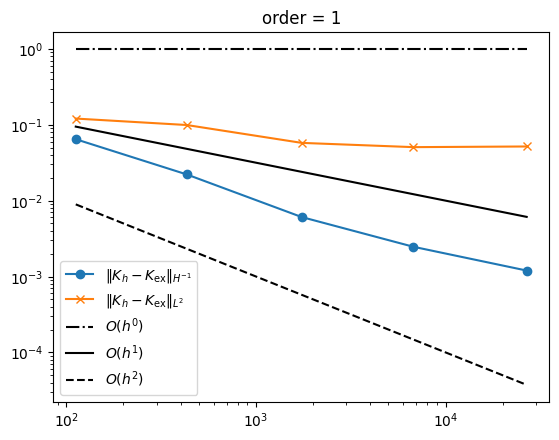

In [5]:
import matplotlib.pyplot as plt

plt.plot(ndof, err_hm1, "-o", label=r"$\|K_h-K_{\mathrm{ex}}\|_{H^{-1}}$")
plt.plot(ndof, err_l2, "-x", label=r"$\|K_h-K_{\mathrm{ex}}\|_{L^2}$")
plt.plot(
    ndof,
    [order**order * dof ** (-(order - 1) / 2) for dof in ndof],
    "-.",
    color="k",
    label=f"$O(h^{order-1})$",
)
plt.plot(
    ndof,
    [order**order * dof ** (-(order) / 2) for dof in ndof],
    "-",
    color="k",
    label=f"$O(h^{order})$",
)
plt.plot(
    ndof,
    [order**order * dof ** (-(order + 1) / 2) for dof in ndof],
    "--",
    color="k",
    label=f"$O(h^{order+1})$",
)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title(f"order = {order}")
plt.show()

Observations: Except for $k=2$, we observe the convergence rates
$$
\begin{align*}
\|K_h-K\|_{L^2}\le C h^{k-1},\qquad \|K_h-K\|_{H^{-1}}\le C h^{k}.
\end{align*}
$$
One additional order of convergence is observed for $k=2$ of curving the surface quadratically. This could be a lucky case where the theory of improved convergence rates applies.